# Training of the Extended Mask2Former

In [2]:
# Import Libraries
import sys, os
module_path = os.path.abspath(os.path.join('..'))
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from PIL import Image
from models.extended_mask2former_model import ExtendedMask2Former
from src.utils import metrics

# Training parameters
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
BASE_DATA_PATH = "data/coco2017"

### Set up GPU growth

In [2]:
# Set device we are going to load the model and the data
device = 'mps' if torch.backends.mps.is_available() else "cpu"

### Data Preprocessing 

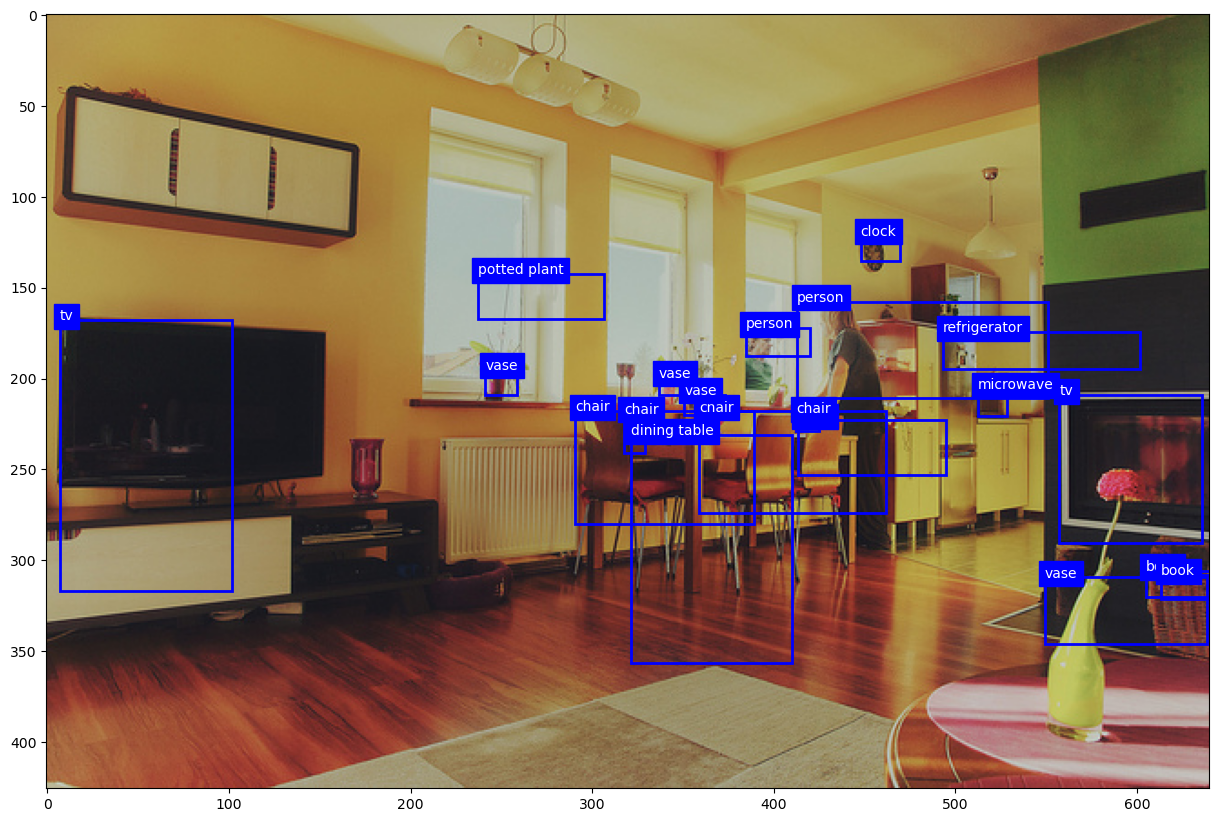

In [4]:
# Define the Transformation function


class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            annotation_file (string): Path to the COCO annotation file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        coco = self.coco
        img_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        
        # Note: You'll need to adjust the targets (e.g., masks, bounding boxes) based on your specific model requirements
        # This example assumes masks are required
        masks = [self.coco.annToMask(ann) for ann in coco_annotation]

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        masks = masks.any(dim=0).unsqueeze(0)  # Combine masks and add channel dimension

        if self.transform is not None:
            image = self.transform(image)
        
        return image, masks

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [ ]:
# Import necessary libraries
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from COCODataset import COCODataset  # Ensure COCODataset class is accessible

# Initialize the COCO dataset
root_dir = 'path/to/coco/images'  # Update this path
annotation_file = 'path/to/annotations/instances_train2017.json'  # Update this path

coco_dataset = COCODataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)

data_loader = DataLoader(coco_dataset, batch_size=4, shuffle=True, num_workers=4)

# Define your model, loss function, and optimizer
# Initialize your model
model = ExtendedMask2Former()  
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = ...  # Define your loss function

# Training loop (simplified)
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in data_loader:
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = loss_fn(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Note: This is a very simplified training loop. You'll need to adjust it based on your model's specific inputs and outputs.
